# Studying 5HT2a receptor ligands using chemical similarity graphs

- Code for the project, Network Analysis 2020, University of Helsinki

In [1]:
# General data wrangling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Network
import networkx as nx
import community # Louvain community detection

# Chemoinformatics
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs, SimDivFilters
from rdkit.Chem import PandasTools

# For following progress of some for-loops...
from tqdm import tqdm

# Other
from itertools import combinations



RDKit WARNING: [17:21:50] Enabling RDKit 2019.09.2 jupyter extensions


# Reading  and processing the dataset

- 5HT2a receptor dataset, [ChEMBL224](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL224/)
- Downloaded as .csv, pandas had trouble opening it, converted to xls with libreoffice calc
- We choose only ChEMBL identifiers, molecular structures, and Ki values
- Those entries with Ki>=50000nM are filtered out
- The RDKit molecule-object is added to the dataframe

In [39]:
df = pd.read_excel("5ht2a.xls")

df_ki = df[df["Standard Type"] == "Ki"]
df_ki = df_ki[["Molecule ChEMBL ID", "Smiles", "Standard Value"]]
df_ki = df_ki.rename(columns={"Standard Value" : "Ki"})
df_ki = df_ki[df_ki.Ki < 50000]
df_ki = df_ki.reset_index(drop=True)
PandasTools.AddMoleculeColumnToFrame(df_ki,'Smiles','rdmol')

# Looking in to the data

In [3]:
df_ki.tail()

,Molecule ChEMBL ID,Smiles,Ki,rdmol
3462,CHEMBL6607,COc1cc(CC(C)N)c(OC)cc1Br,0.60,"<img data-content=""rdkit/molecule"" src=""data:i..."
3463,CHEMBL267930,Fc1ccc(cc1)C(=O)CCCN2CCC3(CC2)N(CNC3=O)c4ccccc4,2.94,"<img data-content=""rdkit/molecule"" src=""data:i..."
3464,CHEMBL42,CN1CCN(CC1)C2=Nc3cc(Cl)ccc3Nc4ccccc24,7.80,"<img data-content=""rdkit/molecule"" src=""data:i..."
3465,CHEMBL1112,Clc1cccc(N2CCN(CCCCOc3ccc4CCC(=O)Nc4c3)CC2)c1Cl,3.60,"<img data-content=""rdkit/molecule"" src=""data:i..."
3466,CHEMBL54,OC1(CCN(CCCC(=O)c2ccc(F)cc2)CC1)c3ccc(Cl)cc3,100.00,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [4]:
print(f"Size of dataset: {df_ki.shape[0]}")

Size of dataset: 3467


## Distribution of Ki

- Ki values are poisson distributed


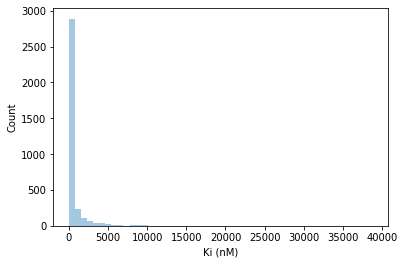

In [5]:
sns.distplot(df_ki.Ki, kde=False)
plt.xlabel("Ki (nM)")
plt.ylabel("Count")
plt.savefig("ki_dist.pdf")

In [6]:
df_ki.Ki.describe()

count     3467.000000
mean       697.273004
std       2553.677428
min          0.010000
25%          6.800000
50%         42.000000
75%        383.010000
max      38815.040000
Name: Ki, dtype: float64

# Computation of similarity matrix

- We first compute all the fingerprint vectors and store them to an array
- All combinations of molecules are gone through, values stored to a matrix

In [7]:
fps = [Chem.RDKFingerprint(i) for i in df_ki.rdmol]
n = df_ki.shape[0]
similarity_matrix = np.zeros((n,n))
for i,j in tqdm(combinations(range(n), r=2)):
    # calculate tanimoto coefficient
    tanimoto_coef = DataStructs.FingerprintSimilarity(fps[i],fps[j])
    similarity_matrix[i,j] = tanimoto_coef

6008311it [00:32, 184333.25it/s]


In [8]:
np.save("similarity_matrix_5ht2a", similarity_matrix)
#similarity_matrix = np.load("similarity_matrix_5ht2a.npy")

In [9]:
def rho(a,t):
    """
    Takes in a similarity matrix and calculates its edge density given a threshold t
    """
    edges = a[np.where(a>t)].shape[0]
    n = a.shape[0]
    p = 2*edges/(n*(n-1))
    return p

## Calculation of edge density as a function of cutoff

In [10]:
ts = np.linspace(0,1,100)
rhos = [rho(similarity_matrix, t) for t in ts]

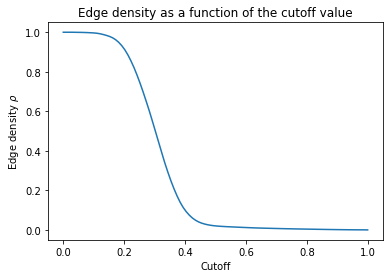

In [11]:
plt.plot(ts,rhos)
plt.xlabel("Cutoff")
plt.ylabel(r"Edge density $\rho$")
plt.title("Edge density as a function of the cutoff value")
plt.savefig("edgedensity_5ht2a.pdf")

# Chemical similarity graph
- We chose the cutoff $t=0.7$ as it's commonly used as a rule of thumb for "similar enough" in pharmaceutical tasks. This way we get ~40k instead of ~12 million possible edges, an amenable amount

In [12]:
def sim_mat_to_g(s,t):
    """
    Takes in a similarity matrix and a threshold value, transforms it to a chemical similarity graph
    """
    a = s.copy()
    a[a<t] = 0
    a[a>=t] = 1
    g = nx.from_numpy_array(a)
    return g

In [13]:
g = sim_mat_to_g(similarity_matrix, 0.7)

In [40]:
print("Number of edges: {}".format(g.number_of_edges()))

Number of edges: 43612


In [14]:
nx.write_edgelist(g,"5ht2a_0.7.edgelist", data=False)
#g = nx.read_edgelist("5ht2a_0.7.edgelist")

In [15]:
edge_density = g.number_of_edges()/(3467*3466)
print("Edge density with t=0.7 : {:.5f}".format(edge_density))

Edge density with t=0.7 : 0.00363


## Structure of the network

- We search for the connected components in the graph

In [17]:
graph_components = [g.subgraph(i) for i in sorted(nx.connected_components(g), key=len, reverse=True)]
sizes_of_connected_components = [i.number_of_nodes() for i in graph_components]

In [18]:
print("Number of components in the graph: {}".format(len(graph_components)))

Number of components in the graph: 441


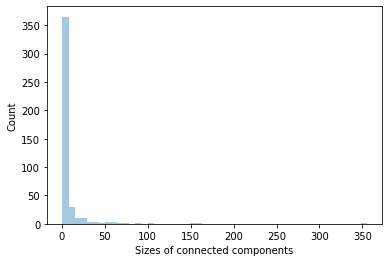

In [19]:
sns.distplot(sizes_of_connected_components, kde=False)
plt.xlabel("Sizes of connected components")
plt.ylabel("Count")
plt.savefig("size_of_concomps.pdf")

- Lets plot the largest subgraph

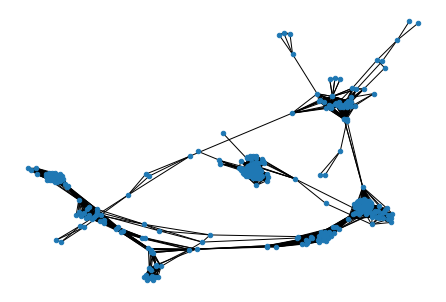

In [20]:
maxsize=0
for i in graph_components:
    if i.number_of_nodes() > maxsize:
        largest_subgraph = i
        maxsize=i.number_of_nodes()
nx.draw_spring(largest_subgraph,node_size=20)
plt.savefig("largest_concomp.pdf")

# Community detection

- We use the [Louvain algorithm](https://python-louvain.readthedocs.io/)


In [21]:
pps = community.best_partition(g)
communities_to_dict = {}
for k, v in pps.items():
    if v not in communities_to_dict:
        communities_to_dict[v] = []
    communities_to_dict[v].append(k)

## Spring plot of the graph, coloured by community id

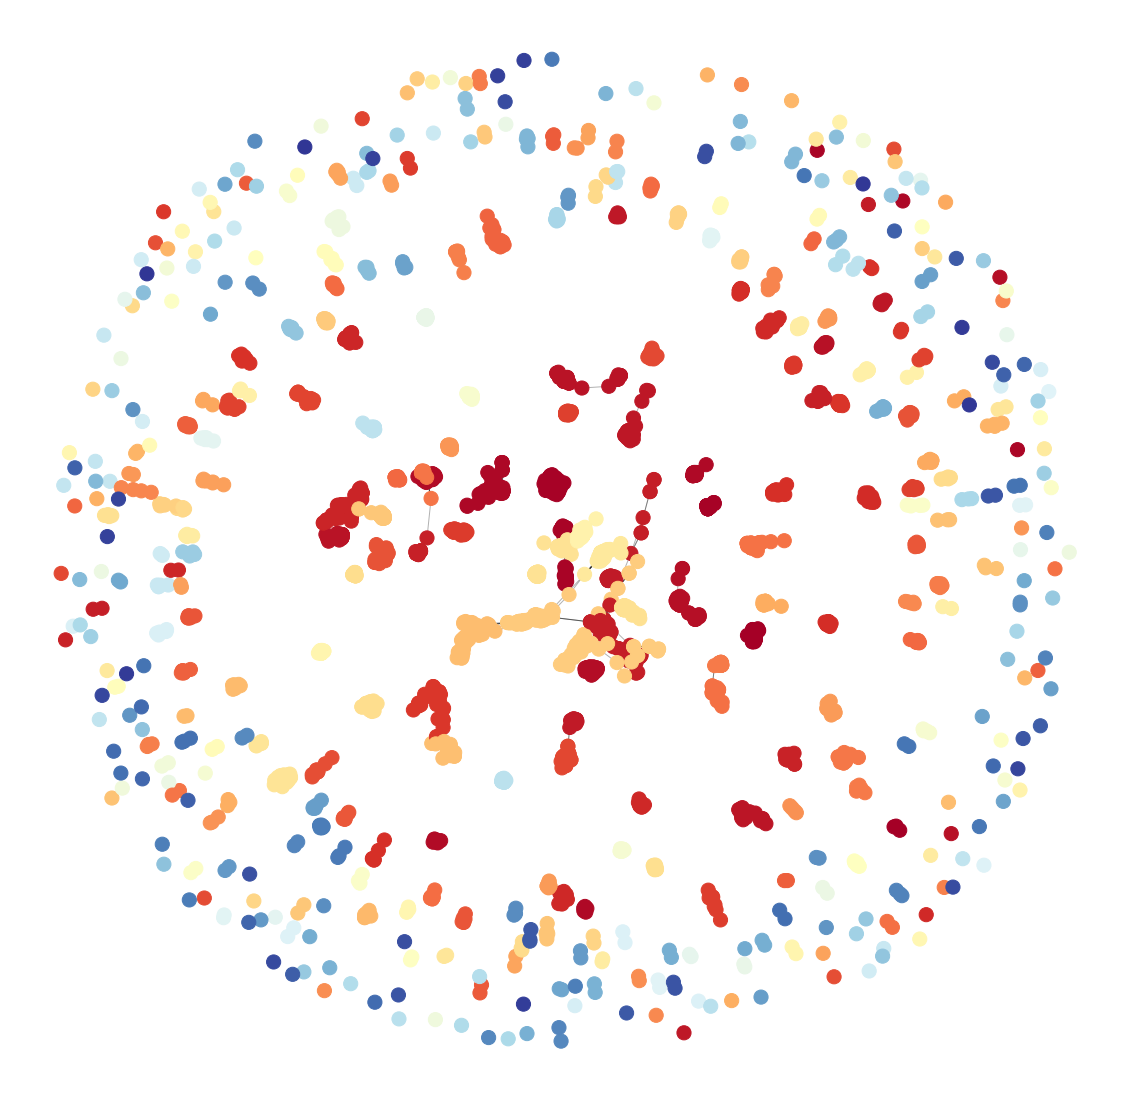

In [22]:
partition = pps
pos = nx.spring_layout(g)
plt.figure(figsize=(20, 20))
plt.axis('off')
nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(g, pos, alpha=0.3)
plt.savefig("graph_coloured.pdf")
plt.show(g)


In [23]:
all_communities = [g.subgraph(nodes) for nodes in communities_to_dict.values()]

In [24]:
print("Number of communities {}".format(len(all_communities)))

Number of communities 448


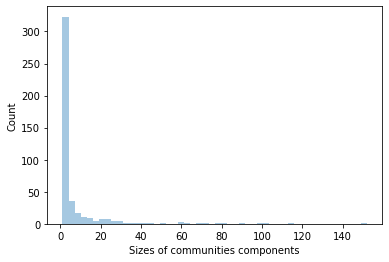

In [25]:
sns.distplot([i.number_of_nodes() for i in all_communities], kde=False)
plt.xlabel("Sizes of communities components")
plt.ylabel("Count")
plt.savefig("size_of_communities.pdf")

# Finding archetypes 

- Filter communities with less than 20 members
    - Arbitrary amount
- Variable name island is used, chemotype would be more suitable...

In [26]:
min_island = 20
islands = [g.subgraph(nodes) for nodes in communities_to_dict.values() if len(nodes) >= min_island]

In [27]:
print("Number of chemotypes {} (with more than 20 members)".format(len(islands)))

Number of chemotypes 48 (with more than 20 members)


- For each chemotype we...
    - Find the node with largest degree centrality = "archetype"
    - Compute standard deviation of $K_i$ values
    - Compute average clustering coefficient
- Values stored in a dict, ugly and pragmatic

In [28]:
def most_central_node(graph, n=5):
    """
    Returns the indices of n nodes with largest degree centrality
    """
    degcents = nx.degree_centrality(graph)
    degcents = sorted(degcents.items(), key=lambda x: x[1], reverse=True)
    most_central = [degcents[i][0] for i in range(n)]
    return most_central

In [29]:
islands_data = {}
for i, chemotype in enumerate(islands):

    data = {}
    most_central = most_central_node(chemotype)[:1]
    
    # archetypal molecule
    data["archetype"] = df_ki.iloc[most_central].rdmol.values[0]
    
    # clustering coef
    data["avg_clustering"] = nx.average_clustering(chemotype)
    # Ki data
    nodes = list(chemotype.nodes)
    df_chemotype = df_ki.iloc[nodes]   
    data["ki_spread"] = np.std(df_chemotype.Ki)
    
    # add to main dict
    islands_data[i] = data

## Drawing the archetypal molecule for each chemotype

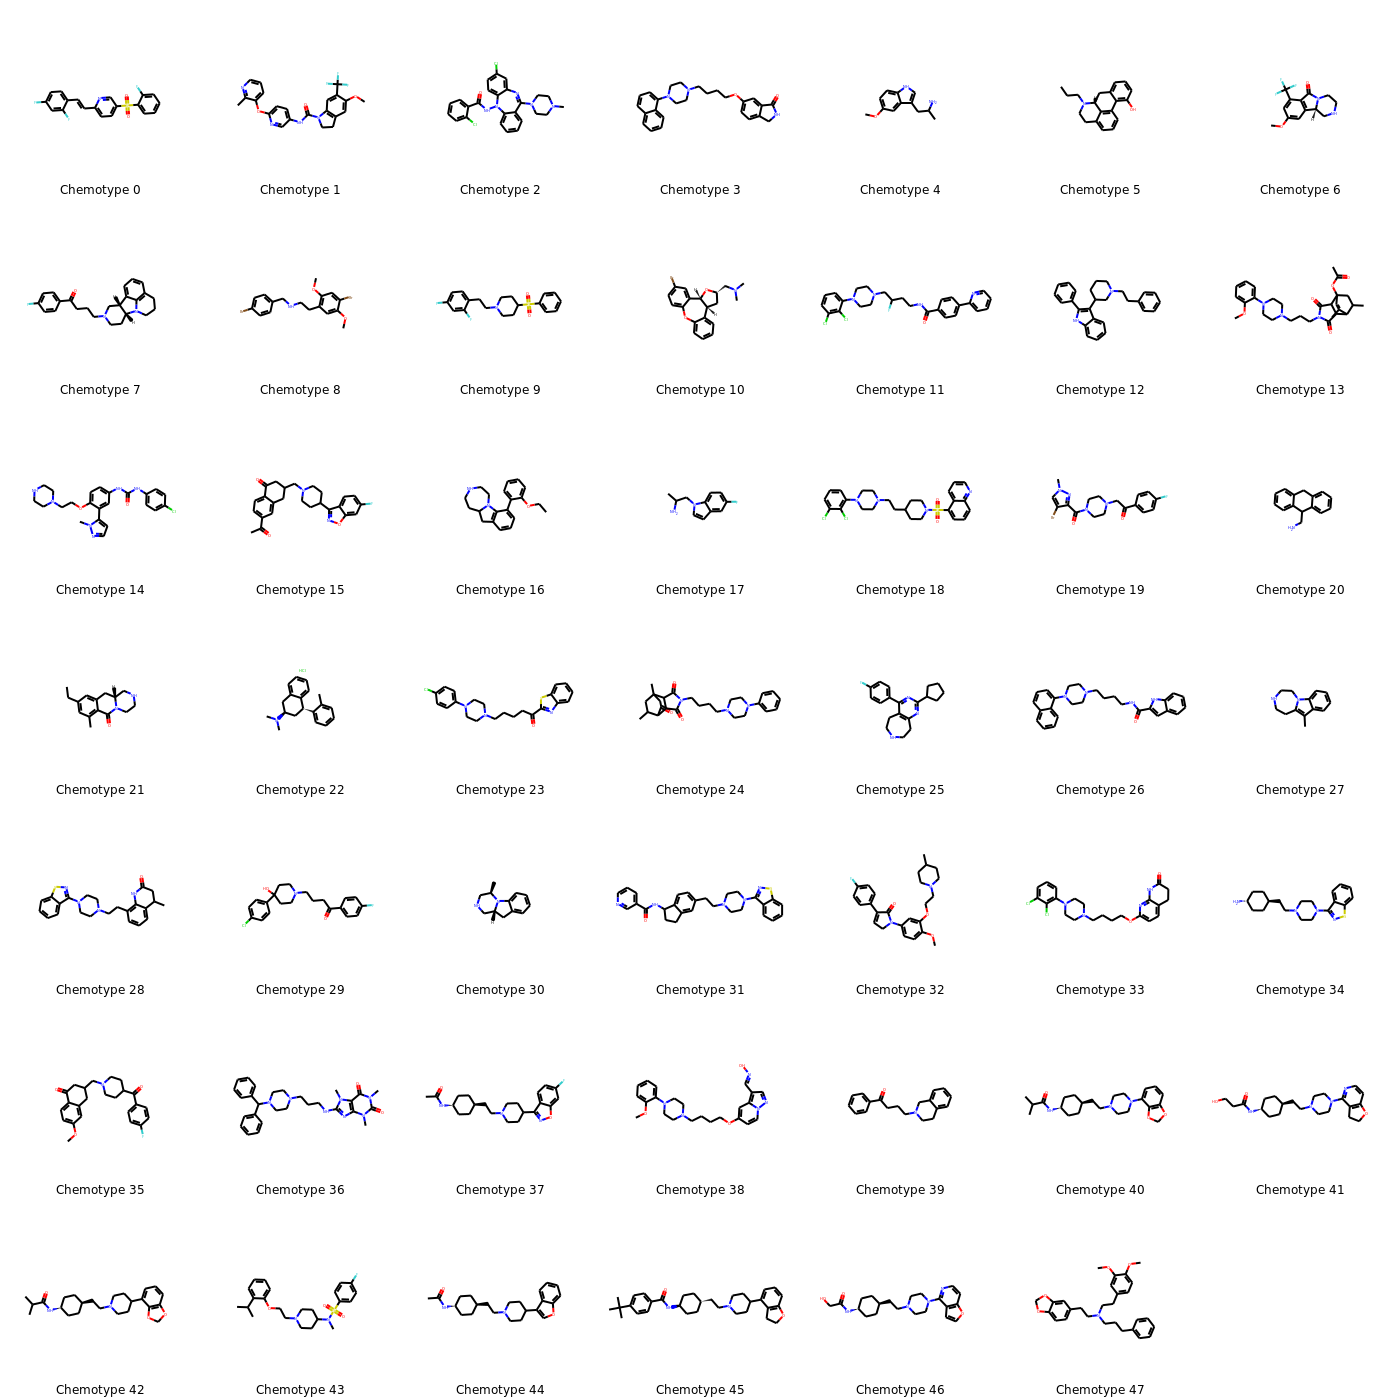

In [30]:
mols = [v["archetype"] for v in islands_data.values()]
#legends = ["#{}, Ki std {:.1f}, clust. {:.2f}".format(k, v["ki_spread"], v["avg_clustering"]) for k,v in islands_data.items()]
legends = ["Chemotype {}".format(k) for k,v in islands_data.items()]
img = Draw.MolsToGridImage(mols,molsPerRow=7,subImgSize=(200,200),legends=legends)
img.save('islands.png')
img

- Histogram of standard deviations of Ki values for each chemotype

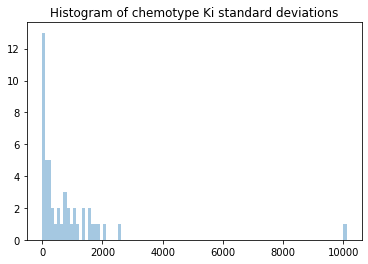

In [37]:
ki_spread = [i["ki_spread"] for i in islands_data.values()]
sns.distplot(ki_spread,kde=False,bins=100)
plt.title("Histogram of chemotype Ki standard deviations")
plt.savefig("ki_std_hist.pdf")

- Relationship with average clustering coefficient and Ki values

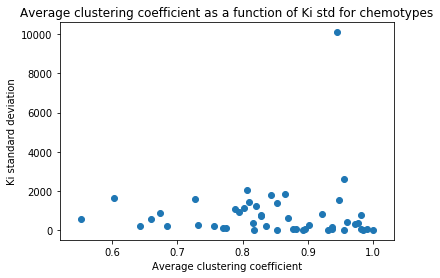

In [36]:
clustering = [i["avg_clustering"] for i in islands_data.values()]
plt.xlabel("Average clustering coefficient")
plt.ylabel("Ki standard deviation")
plt.title("Average clustering coefficient as a function of Ki std for chemotypes")
plt.scatter(clustering, ki_spread)
plt.savefig("avg_clust_ki.pdf")